-----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Librerias

In [1]:
import pandas as pd
import json
from collections import defaultdict
import re
import numpy as np
from utils.utilities import Tiempo
import utils.dataExtraction
import statistics
import keyword
import re
import matplotlib.pyplot as plt
import mplcursors

import xml.etree.ElementTree as ET

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que extrae los timestamps de inicio y fin de cada intentos de nivel
#### También extrae las estrellas obtenidas en cada intentos y cuantas veces se han intentado todos los niveles por cada jugador 

In [2]:
def extraerTiemposPorNivelJugador(rawData):
    
    tiempos = defaultdict(defaultdict)
    intentosNecesarios = defaultdict(defaultdict)
    
    erLevel = re.compile(r'\blevel$\b')
    erIdLevel = re.compile(r'/')
    
    erInitialized = re.compile(r'\binitialized$\b')
    erCompleted = re.compile(r'\bcompleted$\b')
    
    for evento in rawData:
        verb = evento["verb"]["id"]
        obj = evento["object"]["definition"]["type"]
        name = evento["actor"]["name"]
        timestamp = evento["timestamp"]
        objectId = evento["object"]["id"]
        
        if erLevel.search(obj): #Si el objeto de la acción es un nivel
            levelCode = erIdLevel.split(objectId)[-1]
            if levelCode != "editor_level":
                if erInitialized.search(verb): #Si la acción es inicio o reinicio
                    if "result" in evento: #Significa que ha iniciado el nivel desde el menu
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode].append({"intentos" : 1, "success" : False})
                            tiempos[name][levelCode].append({"ini" : timestamp, "fin" : None, "stars" : ""})
                        else:
                            intentosNecesarios[name][levelCode] = [{"intentos" : 1, "success" : False}]
                            tiempos[name][levelCode] = [{"ini" : timestamp, "fin" : None, "stars" : ""}]
                    else:
                        intentosNecesarios[name][levelCode][-1]["intentos"] += 1
                elif erCompleted.search(verb):
                    if evento["result"]["score"]["raw"] > 0 :
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode][-1]["success"] = True
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]

                    elif evento["result"]["score"]["raw"] == -1:
                        if levelCode in tiempos[name]:
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]
    
    return {"tiempos" : tiempos, "intentosNecesarios" : intentosNecesarios}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que resta los timestamps de inicio y fin de cada intento de nivel para sacar la diferencia de tiempo

In [3]:
def tiempoPorNiveles_Jugador(data):
    tiemposJugados = defaultdict(defaultdict)
    for player in data:
        for level in data[player]:
            for times in data[player][level]:
                if times["fin"] != None: #Si no se aborto el intento del nivel
                    timeDifference = Tiempo(times["ini"], times["fin"])
                    if level in tiemposJugados[player]:
                        tiemposJugados[player][level].append({"time" : timeDifference, "stars" : times["stars"]})
                    else:
                        tiemposJugados[player][level] = [{"time" : timeDifference, "stars" : times["stars"]}]
    return tiemposJugados

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que devuelve el tiempo medio necesario para completar un nivel y un diccionario con el tiempo empleado por cada jugador hasta completar el nivel
(El tiempo necesario para cada jugador es la suma de todos los tiempos hasta conseguir completar el nivel)
* También devuelve la media de estrellas y una lista de los niveles ordenados

In [4]:
#TAMBIEN DEVUELVE EL TIEMPO INDIVIDUAL DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getMediaTiempoPorNivel(tiempos, soloPrimerExito = True, tiemposOrdenados = False):
    medias = defaultdict(list)
    mediasEstrellas = defaultdict(list)
    tiempoCompletarNivelIndividual = defaultdict(defaultdict)
    
    for player in tiempos:
        for level in tiempos[player]:
            tAux = Tiempo("0s")
            for t in tiempos[player][level]:
                if t["stars"] != -1:
                    if level in medias:
                        medias[level].append(int(tAux + t["time"]))
                        mediasEstrellas[level].append(int(t["stars"]))
                    else:
                        medias[level] = [int(tAux + t["time"])]
                        mediasEstrellas[level] = [int(t["stars"])]
                        
                    tiempoCompletarNivelIndividual[player][level] = tAux + t["time"]
                    if soloPrimerExito:
                        break
                elif t["stars"] == 0:
                    print("ALERTA")
                else:
                    tAux += t["time"]
    for m in medias:
        medias[m] = Tiempo(str(int(round(statistics.mean(medias[m]), 0))) + "s")
        
    for m in mediasEstrellas:
        mediasEstrellas[m] = statistics.mean(mediasEstrellas[m])
    
    listaNiveles = medias.keys()
    
    if tiemposOrdenados:
        medias = sorted(medias.items(), key=lambda x: x[1])
        mediasEstrellas = sorted(mediasEstrellas.items(), key=lambda x: x[1])
    else:
        medias = list(medias.items())
        mediasEstrellas = list(mediasEstrellas.items())
    
    return {"mediaTiempos" : medias, "mediaEstrellas" : mediasEstrellas, "listaNiveles" : listaNiveles, "tiemposIndividuales" : tiempoCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve un diccionario con clave: id Jugador y valor: ultimo nivel alcanzado

In [5]:
def getUltimoNivelAlcanzado(tiempos):
    ultNivel = defaultdict()
    for player in tiempos:
        for level in tiempos[player]:
            ultNivel[player] = level
    return ultNivel

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve los intentos necesarios de cada jugador para completar un nivel al igual que los intentos medios

In [6]:
#TAMBIEN DEVUELVE LOS INTENTOS INDIVIDUALES DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getIntentosMedios_HastaCompletarNivel(intentosNecesarios, intentosOrdenados = False):
    intentosMedios = defaultdict(list)
    intentosCompletarNivelIndividual = defaultdict(defaultdict)
    
    for name in intentosNecesarios:
        for level in intentosNecesarios[name]:
            cont = 0
            for i in intentosNecesarios[name][level]:
                cont += i["intentos"]
                if i["success"] == True:
                    intentosMedios[level].append(cont)
                    intentosCompletarNivelIndividual[name][level] = cont
                    break
            
    for level in intentosMedios:
        intentosMedios[level] = round(statistics.mean(intentosMedios[level]), 2)
    
    if intentosOrdenados:
        intentosMedios = sorted(intentosMedios.items(), key=lambda x: x[1])
    else:
        intentosMedios = list(intentosMedios.items())
    return {"intentosMedios" : intentosMedios, "intentosIndividual" : intentosCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Transforma un diccionario de diccionarios en un diccionario de arrays
* Se utiliza para tener una lista de todos los tiempos de los usuarios cuando tenemos un diccionario dentro de otro con primera clave nombre usuario y segunda clave codigo del nivel

In [7]:
def extraerArray(my_dict):
    nested_keys = []
    nested_values = []

    for k, v in my_dict.items():
        for nested_k, nested_v in v.items():
            nested_keys.append(nested_k)
            nested_values.append(nested_v)

    # create a dictionary with keys as the values of the nested_keys array
    nested_dict = defaultdict(list)
    for key, value in zip(nested_keys, nested_values):
        nested_dict[key].append(value)
    
    return nested_dict

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Recibe un diccionario con clave nivel y valor una lista de tiempos y parsea los tiempos a integer

In [8]:
def parseTiemposDictToInteger(data_dict):
    parsed_dict = {}

    for key, value in data_dict.items():
        parsed_list = []
        for element in value:
            parsed_list.append(int(element))
        parsed_dict[key] = parsed_list

    return parsed_dict

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que genera los boxplots recibiendo un diccionario con clave nivel y valor una lista de enteros

In [9]:
def create_boxplots(data_dict):
    # Group levels by category
    category_dict = {}
    for level, data in data_dict.items():
        category = level.split('_')[0]
        if category in category_dict:
            category_dict[category].append(data)
        else:
            category_dict[category] = [data]
    
    # Create boxplots for each category and add relevant information
    boxplots = []
    labels = []
    for i, (category, data_list) in enumerate(category_dict.items()):
        fig, ax = plt.subplots()
        bp = ax.boxplot(data_list, showfliers=True, patch_artist=True, flierprops={'marker': '+', 'markerfacecolor': '#738FA7'})
        ax.set_title(category)

        color = '#738FA7'
        for patch in bp['boxes']:
            patch.set_facecolor(color)
        
        boxplots.append(bp)
        labels.append(category)
    
    # Set tick labels
    fig, ax = plt.subplots()
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelrotation=45)
    
    return boxplots


In [10]:
def getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles):
    cuantosHanLlegadoAlNivel = defaultdict()
    
    ultNivelCopia = ultNivelCompletado.copy()

    #Contamos cuanta gente ha llegado hasta cada nivel
    for nivel in niveles:
        cuantosHanLlegadoAlNivel[nivel] = len(ultNivelCopia)
        
        keys_to_delete = [k for k, v in ultNivelCopia.items() if v == nivel]
        for k in keys_to_delete:
            del ultNivelCopia[k]

    return cuantosHanLlegadoAlNivel

In [11]:
def generateChartNivelesAlcanzados(niveles, ultNivelCompletado):
    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)

    category_dict = {}
    for level, value in cuantosHanLlegadoAlNivel.items():
        category = level.split('_')[0]
        level_number = int(level.split('_')[-1])
        if category in category_dict:
            category_dict[category].append((level_number, value))
        else:
            category_dict[category] = [(level_number, value)]
    for category, levels in category_dict.items():
        category_dict[category] = sorted(levels, key=lambda x: x[0])

    # Select the last level for each category
    last_levels = {}
    for category, levels in category_dict.items():
        last_level = levels[-1][0]
        last_levels[category] = levels[-1][1]

    # Create bar chart and add labels
    fig, ax = plt.subplots()
    ax.bar(last_levels.keys(), last_levels.values(), color="#738FA7")
    ax.set_xticklabels(last_levels.keys(), rotation=45, ha='right')
        
    plt.show()

In [12]:
def getChartPorcentajeCategorias(niveles, ultNivelCompletado, total_players):

    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)

    ultimoNivelCat = {}
    for level in niveles:
        category = level.split("_")[0]
        ultimoNivelCat[category] = level
    
    percentages = {}
    for ultNivel in ultimoNivelCat.values():
        percentages[ultNivel] = (cuantosHanLlegadoAlNivel[ultNivel]/total_players)*100
    
    fig, ax = plt.subplots()
    ax.bar(range(len(percentages)), list(percentages.values()), align='center', color="#738FA7")
    ax.set_xticks(range(len(percentages)))
    ax.set_xticklabels(map(lambda c: c.split("_")[0], list(percentages.keys())), rotation=45, ha='right')
    ax.set_ylim((0, 100))
    ax.set_ylabel('Porcentaje Jugadores')
    ax.set_xlabel('Categorías')
    ax.set_title('Categorías Superadas')
    
    return ax

In [13]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = None

In [16]:
JSONFile = open('./data/trazasOrdenadas.json')
rawData = json.load(JSONFile)
JSONFile.close()

resultados_Tiempos_Nivel_Jugador = extraerTiemposPorNivelJugador(rawData)

In [17]:
tiemposIntentosJugadores = tiempoPorNiveles_Jugador(resultados_Tiempos_Nivel_Jugador["tiempos"])
#pd.DataFrame(tiemposIntentosJugadores)
#pd.DataFrame(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"])

In [18]:
soloPrimerExito = True
tiemposOrdenados = False
tiemposMedios = getMediaTiempoPorNivel(tiemposIntentosJugadores, soloPrimerExito, tiemposOrdenados)
#pd.DataFrame(tiemposMedios["mediaTiempos"])
#pd.DataFrame(tiemposMedios["mediaEstrellas"])
#pd.DataFrame(tiemposMedios["listaNiveles"])
#pd.DataFrame(tiemposMedios["tiemposIndividuales"])

In [19]:
ultNivelAlcanzado = getUltimoNivelAlcanzado(tiemposMedios["tiemposIndividuales"])
#print(ultNivelAlcanzado)

In [20]:
intentosOrdenados = False
intentosMedios_Individual = getIntentosMedios_HastaCompletarNivel(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"], intentosOrdenados)
#pd.DataFrame(intentosMedios_Individual["intentosMedios"])
#pd.DataFrame(intentosMedios_Individual["intentosIndividual"])

In [21]:
tiemposList = extraerArray(tiemposMedios["tiemposIndividuales"])
intentosList = extraerArray(intentosMedios_Individual["intentosIndividual"])
#pd.DataFrame.from_dict(tiemposList, orient='index').transpose()
#pd.DataFrame.from_dict(intentosList, orient='index').transpose()

C:\Users\david\AppData\Local\Temp\ipykernel_22920\3774671035.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(last_levels.keys(), rotation=45, ha='right')


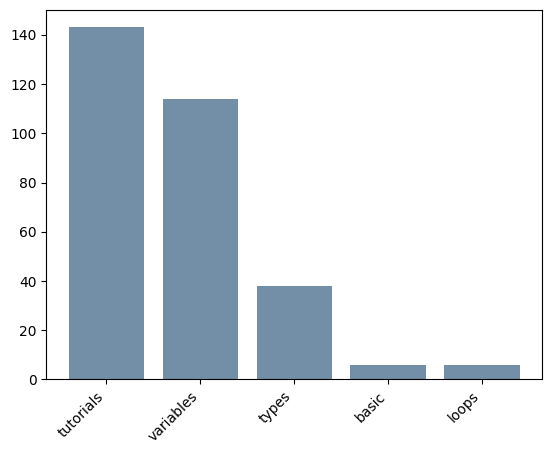

In [22]:
generateChartNivelesAlcanzados(tiemposMedios["listaNiveles"], ultNivelAlcanzado)

<Axes: title={'center': 'Categorías Superadas'}, xlabel='Categorías', ylabel='Porcentaje Jugadores'>

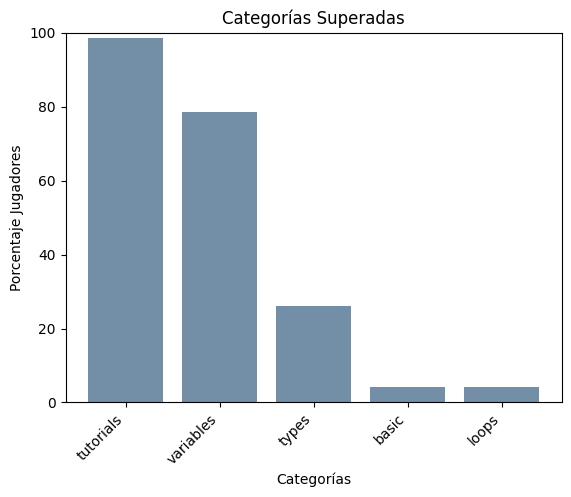

In [23]:
getChartPorcentajeCategorias(tiemposMedios["listaNiveles"], ultNivelAlcanzado, len(ultNivelAlcanzado))

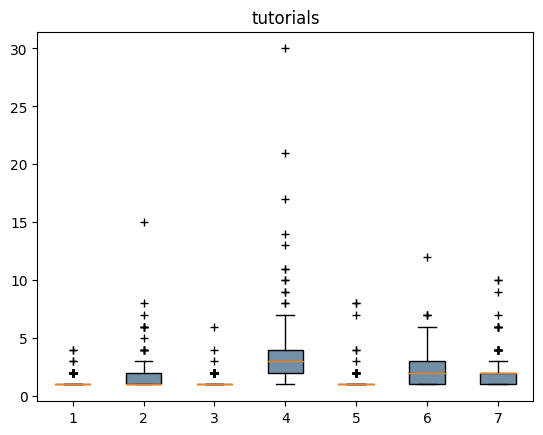

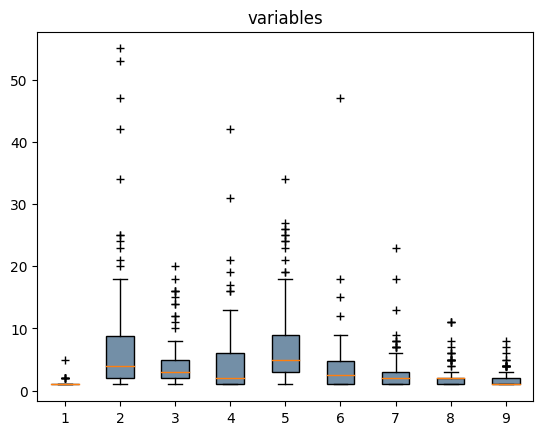

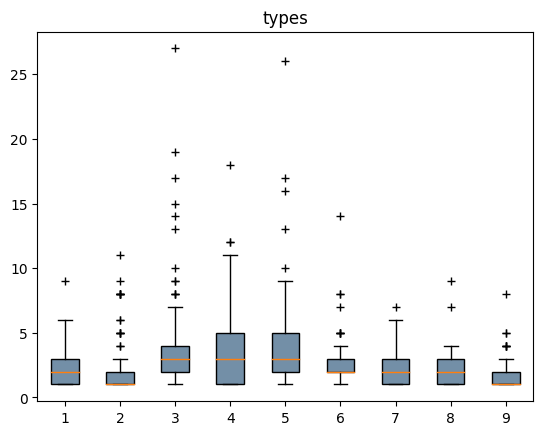

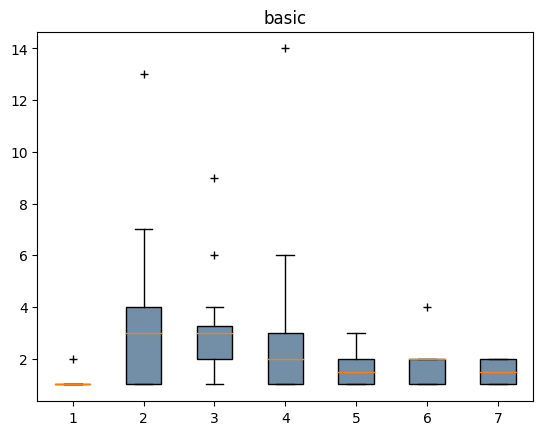

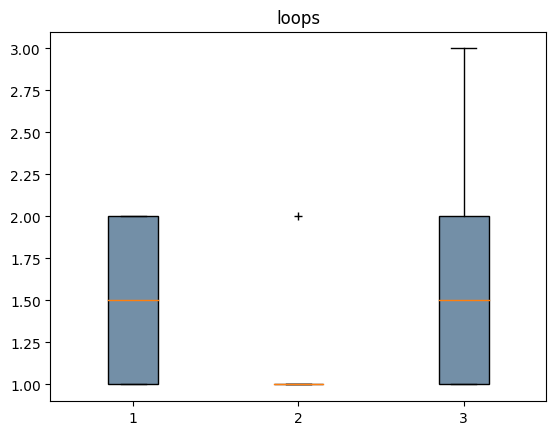

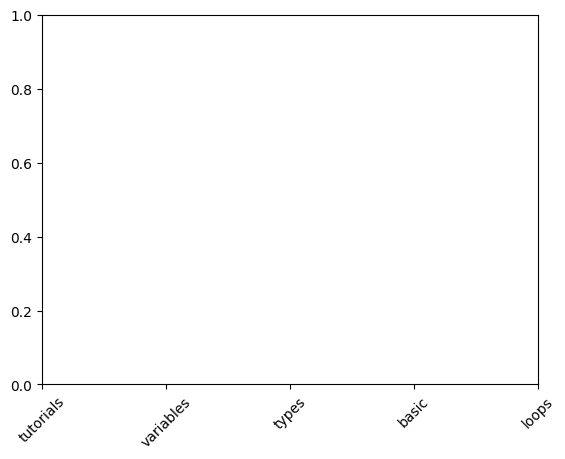

In [24]:
boxplotsIntentos = create_boxplots(intentosList)

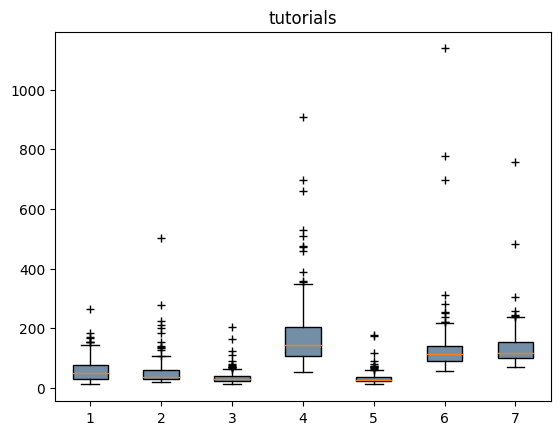

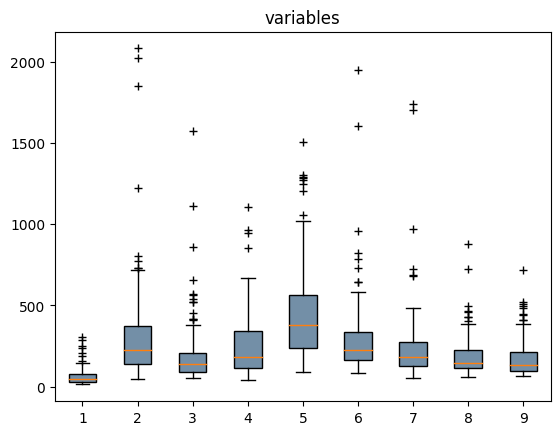

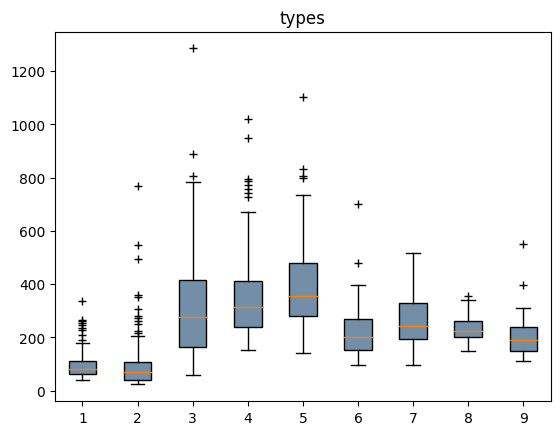

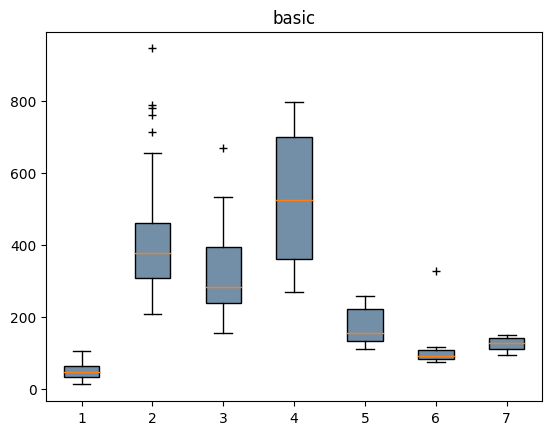

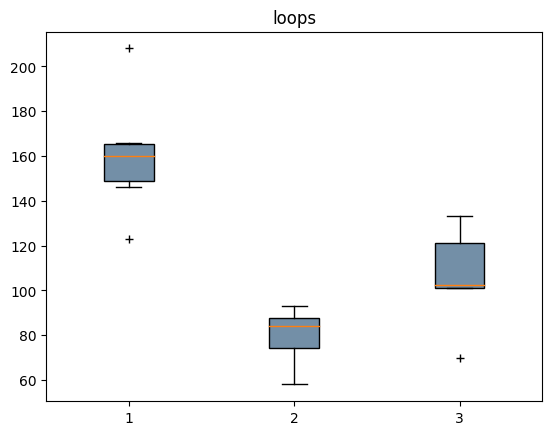

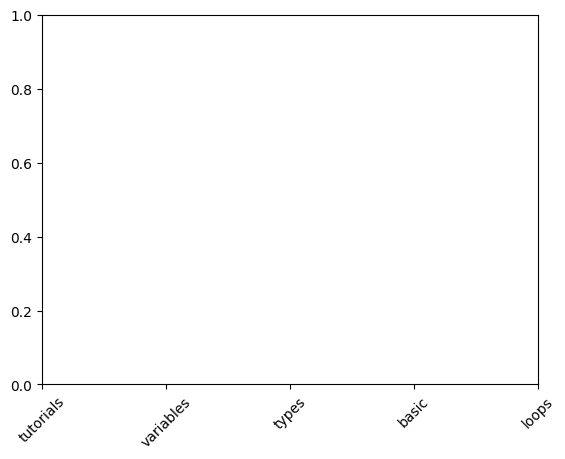

In [25]:
boxplotsTiempos = create_boxplots(parseTiemposDictToInteger(tiemposList))

In [27]:
import plotly.express as px

def create_boxplots2(data_dict):
    categorias = defaultdict(defaultdict)
    for d in data_dict:
        categorias[d.split("_")[0]][d] = data_dict[d]


    boxplots = []
    for c in categorias:
        df = pd.DataFrame.from_dict(categorias[c], orient="index").transpose()
        df_melt = pd.melt(df.reset_index(), id_vars=["index"], value_vars=list(categorias[c].keys()))
        df_melt.columns = ["index", c, "Intentos"]

        fig =px.box(df_melt, x=c, y="Intentos")
        fig.write_json("./plots/"+c+".json")
        fig.show()
        boxplots.append(fig)
        
    
    return boxplots    

boxs= create_boxplots2(intentosList)

FileNotFoundError: [Errno 2] No such file or directory: 'plots\\tutorials.json'

### Clustering

In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [36]:
filename = 'results-survey976727_pre.csv'
data = pd.read_csv(filename, sep=';', header=0)

data.drop(['submitdate', 'G00Q01[SQ01]', 'G02Q01', 'G02Q02', 'G02Q03', 'G02Q04', 'G03Q02[other]', 'id'], axis = 'columns', inplace=True)

#data

In [37]:
# Calcular los límites de los valores atípicos
# regla empírica, que establece que los valores atípicos se encuentran a más de 3 desviaciones estándar de la media.

edad_media = data['G03Q01'].mean()
edad_desv_est = data['G03Q01'].std()
edad_limite_inferior = edad_media - (3*edad_desv_est)
edad_limite_superior = edad_media + (3*edad_desv_est)

# Filtrar el dataframe para eliminar los outliers de edad
data_filtrado = data.loc[(data['G03Q01'] >= edad_limite_inferior) & (data['G03Q01'] <= edad_limite_superior)]

#data_filtrado

In [38]:
# Crear un DataFrame con los datos de los intentos medios de cada jugador en cada nivel
intentosJugadores = pd.DataFrame(intentosMedios_Individual["intentosIndividual"])

# Pivotear el DataFrame para tener un formato largo
intentos_df_long = pd.melt(intentosJugadores.reset_index(), id_vars=['index'], var_name='Jugador', value_name='Intentos')
intentos_df_long.columns = ['Nivel', 'Jugador', 'Intentos']

# Agrupar los intentos de cada jugador por nivel y tomar la media
intentos_jugador_nivel = intentos_df_long.groupby(['Jugador', 'Nivel'])['Intentos'].mean().unstack()

# Unir la tabla de intentos de cada jugador con los datos originales
df = data_filtrado.merge(intentos_jugador_nivel, left_on='token', right_index=True)

# Seleccionar las variables a utilizar para el clustering
X = df.iloc[:, 3:] # Seleccionar las columnas correspondientes a los niveles

# Imputar los valores faltantes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Normalizar las variables utilizando StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_imputed)

# Definir el número de clusters y entrenar el modelo de K-means
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_norm)

# Asignar a cada jugador el cluster correspondiente
clusters = kmeans.labels_
df['Cluster'] = clusters

# Calcular la media de los números de intentos en cada cluster
means = df.groupby(['G03Q02', 'G03Q01', 'Cluster'])[X.columns].mean()

# Mostrar los resultados
print(means) #Dar a abrir en un editor de texto para ver mejor la tabla
#intentosJugadores


                          basic_operators_1  basic_operators_2  \
G03Q02    G03Q01 Cluster                                         
Femenino  8      0                      NaN                NaN   
          12     0                      NaN                NaN   
                 3                     1.00           3.000000   
          13     0                      NaN                NaN   
                 3                     1.00           2.250000   
          14     0                      NaN                NaN   
                 3                     1.00           7.500000   
          15     0                      NaN                NaN   
                 3                     1.00           4.000000   
          17     0                      NaN                NaN   
Masculino 12     0                      NaN                NaN   
                 3                     1.00           4.000000   
          13     0                      NaN                NaN   
          

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [40]:
tiemposJugadores = pd.DataFrame(tiemposMedios["tiemposIndividuales"])

# Aplicar la función int() solamente a los valores que no son NaN en el DataFrame
tiemposJugadores = tiemposJugadores.applymap(lambda x: int(x) if x == x else x)

# Pivotear el DataFrame para tener un formato largo
tiempos_df_long = pd.melt(tiemposJugadores.reset_index(), id_vars=['index'], var_name='Jugador', value_name='Intentos')
tiempos_df_long.columns = ['Nivel', 'Jugador', 'Intentos']

# Agrupar los intentos de cada jugador por nivel y tomar la media
tiempos_jugador_nivel = tiempos_df_long.groupby(['Jugador', 'Nivel'])['Intentos'].mean().unstack()

# Unir la tabla de intentos de cada jugador con los datos originales
df = data_filtrado.merge(tiempos_jugador_nivel, left_on='token', right_index=True)

# Seleccionar las variables a utilizar para el clustering
X = df.iloc[:, 3:] # Seleccionar las columnas correspondientes a los niveles

# Imputar los valores faltantes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Normalizar las variables utilizando StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_imputed)

# Definir el número de clusters y entrenar el modelo de K-means
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_norm)

# Asignar a cada jugador el cluster correspondiente
clusters = kmeans.labels_
df['Cluster'] = clusters

# Calcular la media de los números de intentos en cada cluster
means = df.groupby(['G03Q02', 'G03Q01', 'Cluster'])[X.columns].mean()

# Mostrar los resultados
print(means)
# tiemposJugadores


C:\Users\david\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



                          basic_operators_1  basic_operators_2  \
G03Q02    G03Q01 Cluster                                         
Femenino  8      1                      NaN                NaN   
          12     0                50.000000         780.000000   
                 1                      NaN                NaN   
                 2                      NaN                NaN   
          13     0                74.000000         787.000000   
                 2                53.000000         381.000000   
          14     0                      NaN                NaN   
                 1                      NaN                NaN   
                 2                41.666667         638.000000   
          15     0                      NaN                NaN   
                 1                      NaN                NaN   
                 2                39.000000         360.000000   
          17     1                      NaN                NaN   
Masculino 

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




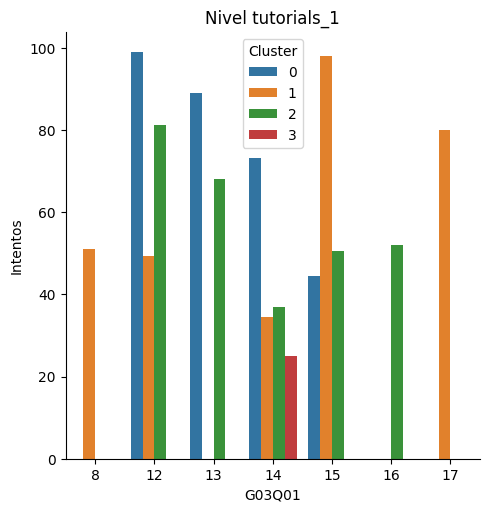

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




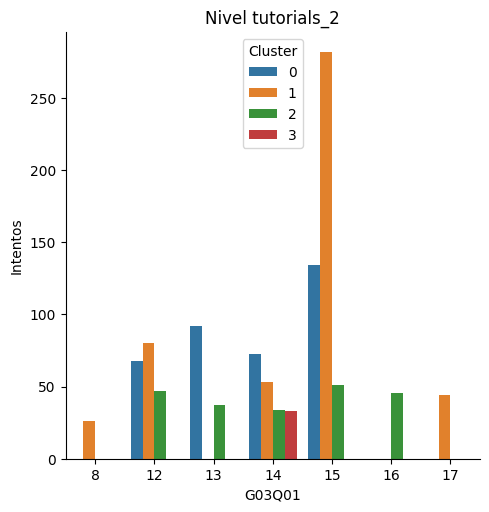

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




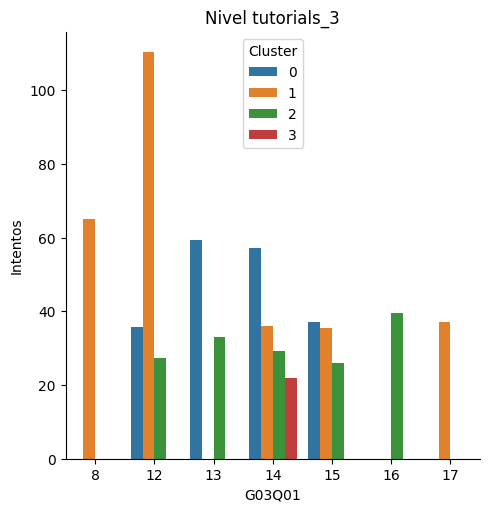

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




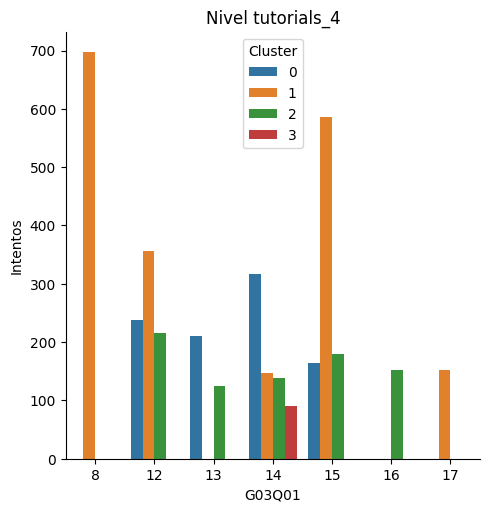

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




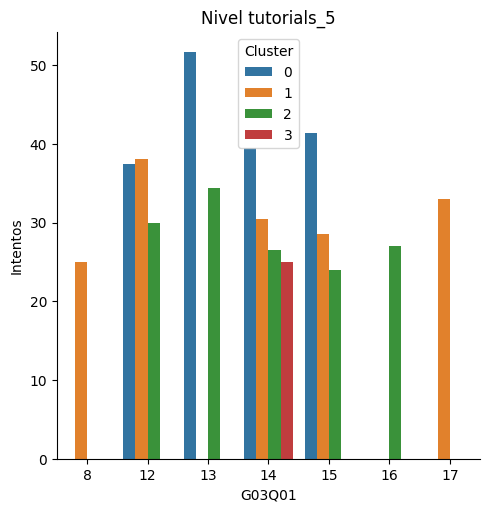

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




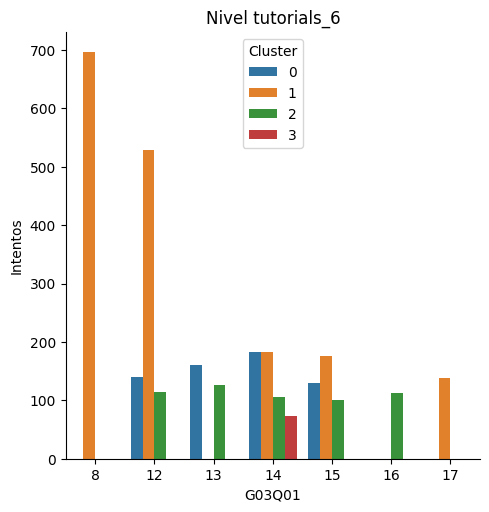

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




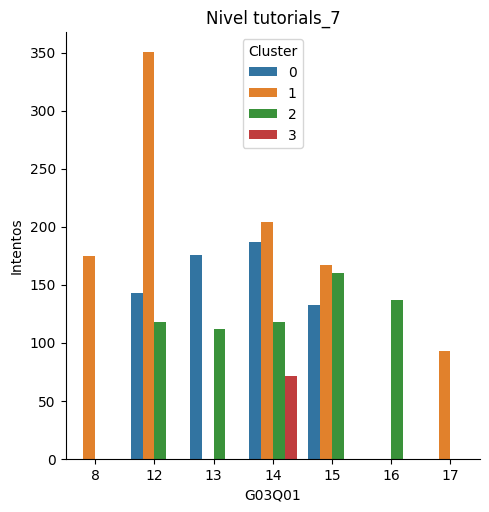

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




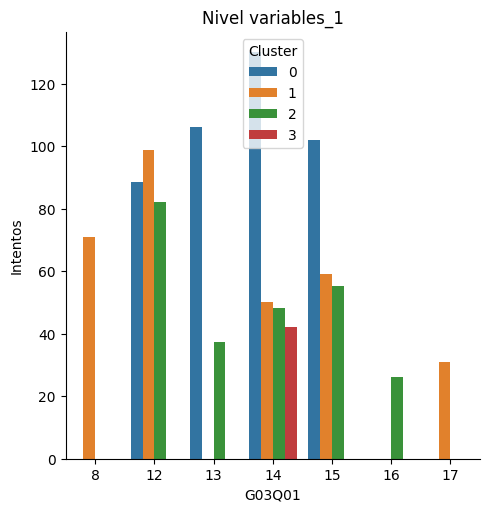

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




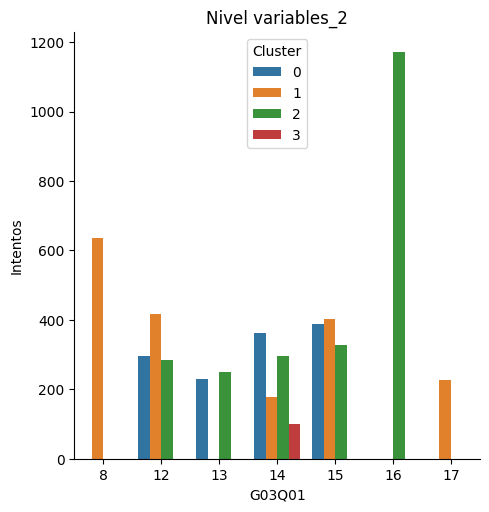

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




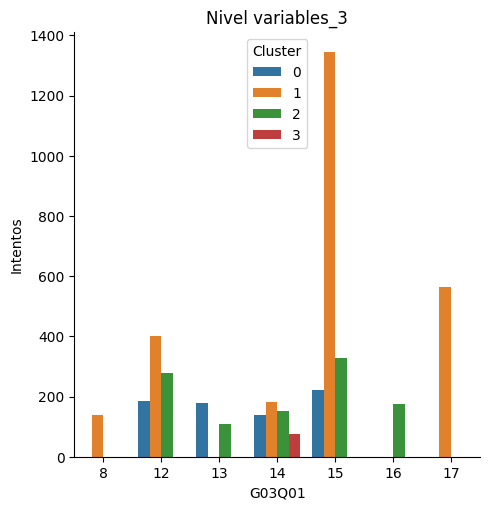

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




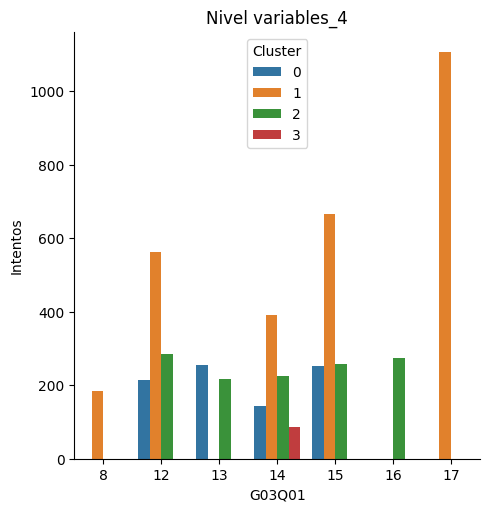

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




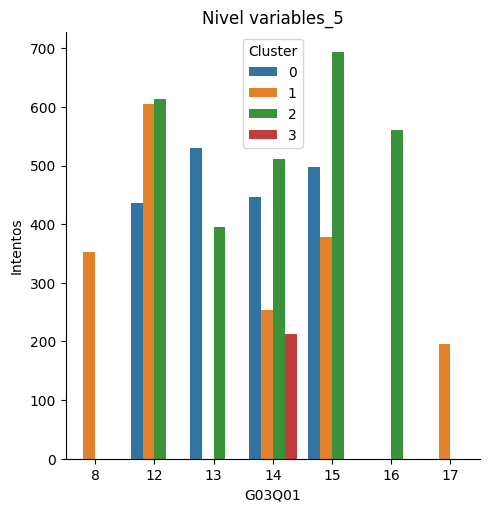

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




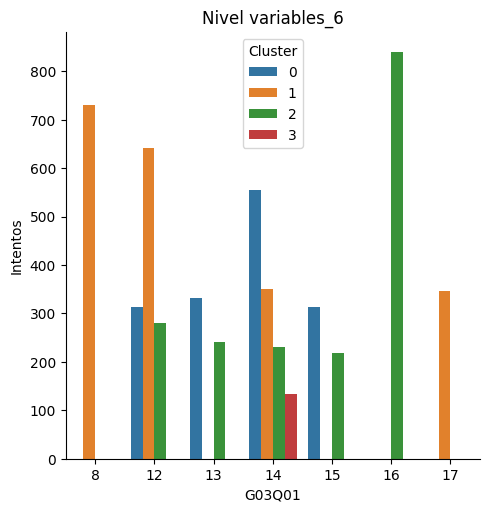

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




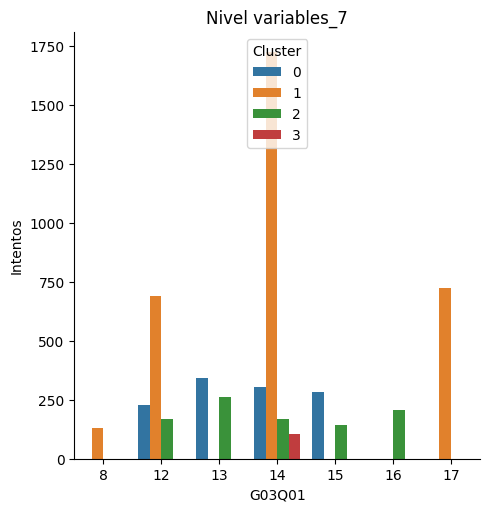

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




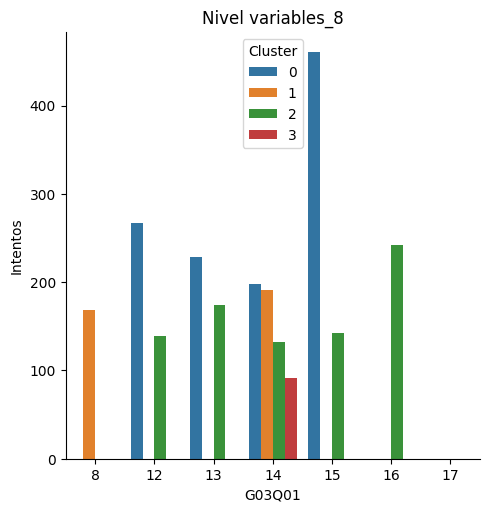

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




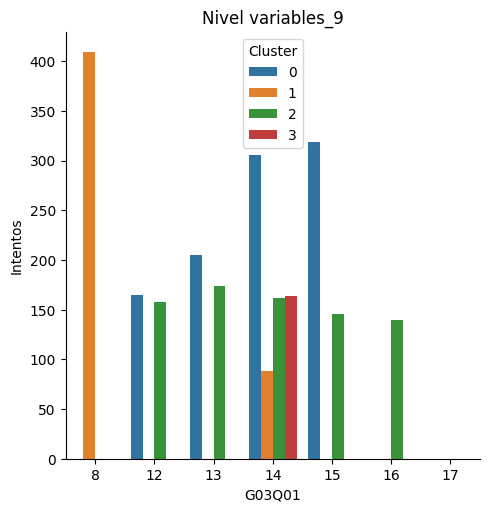

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




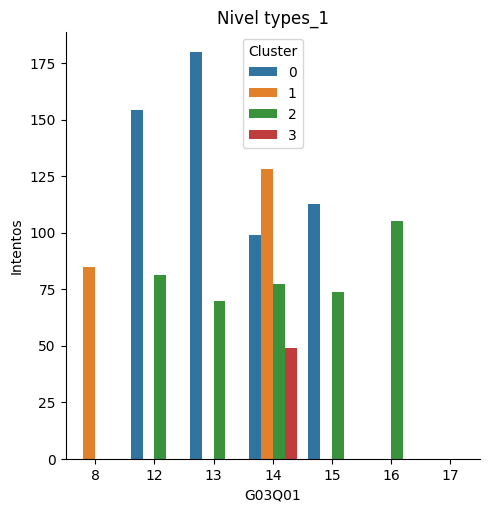

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




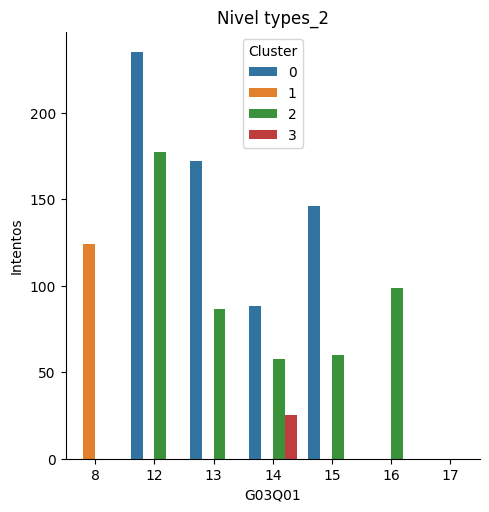

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




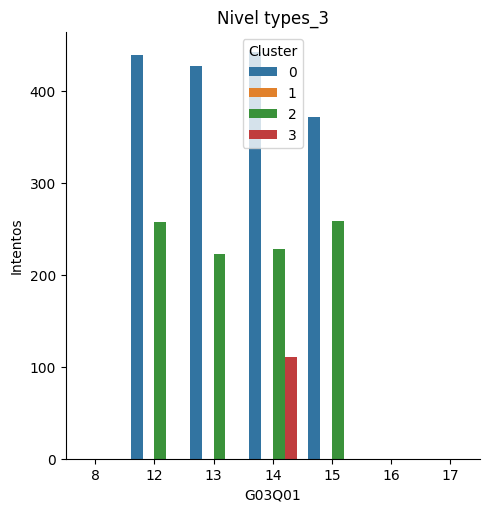

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




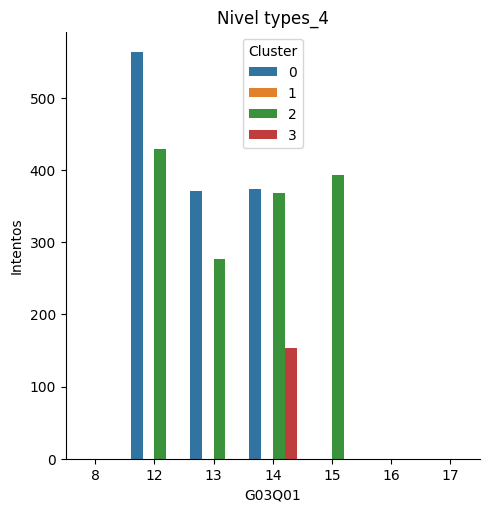

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




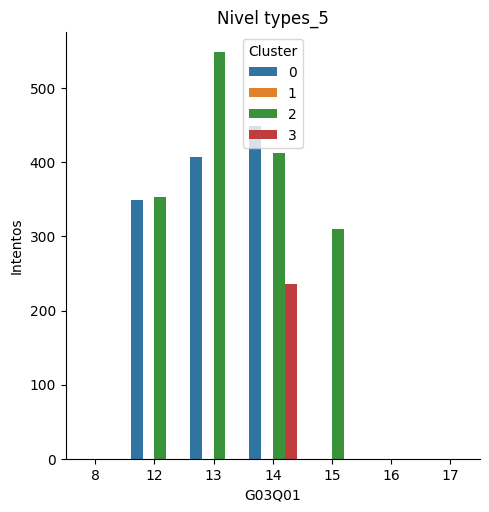

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




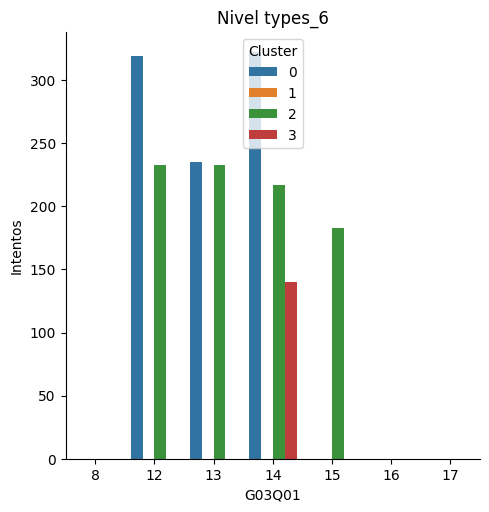

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




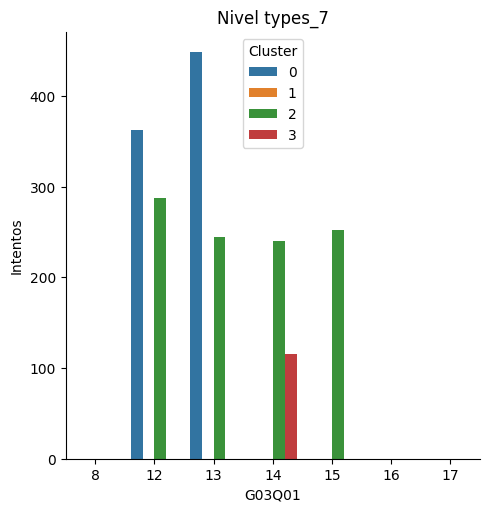

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




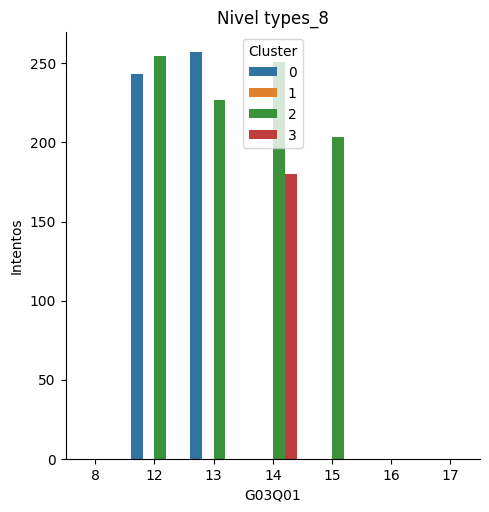

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




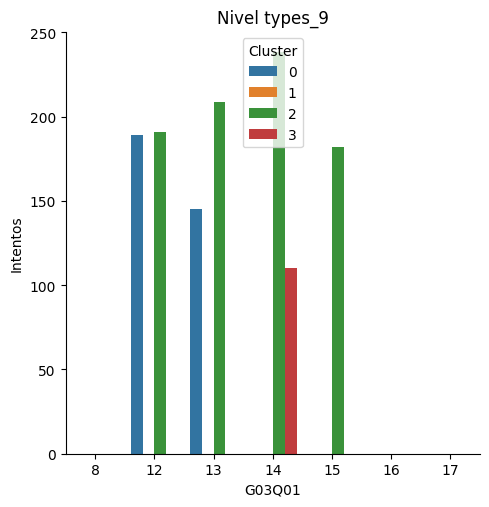

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




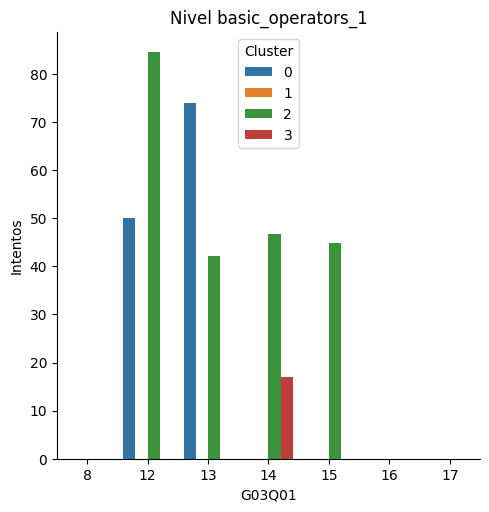

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




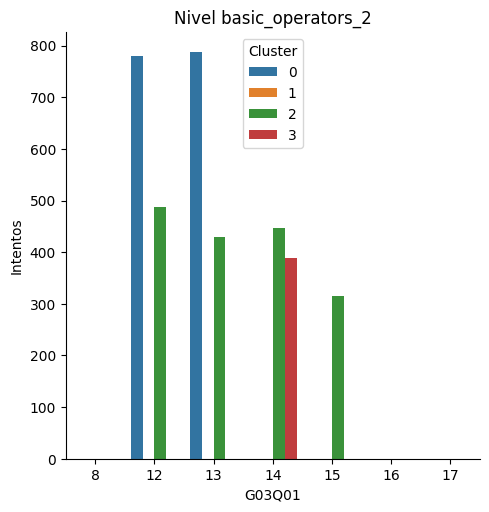

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




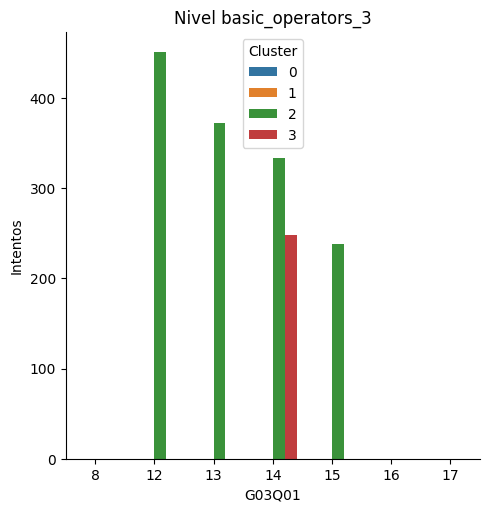

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




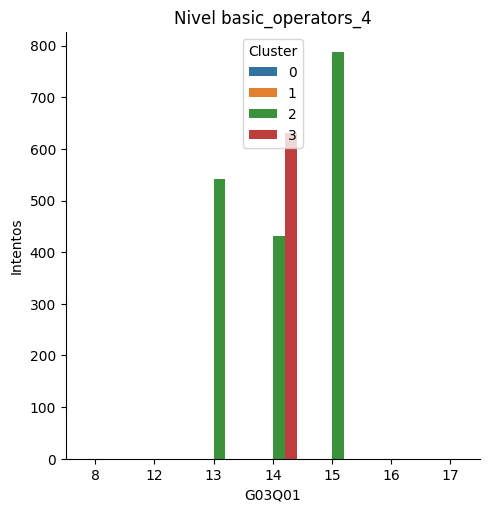

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




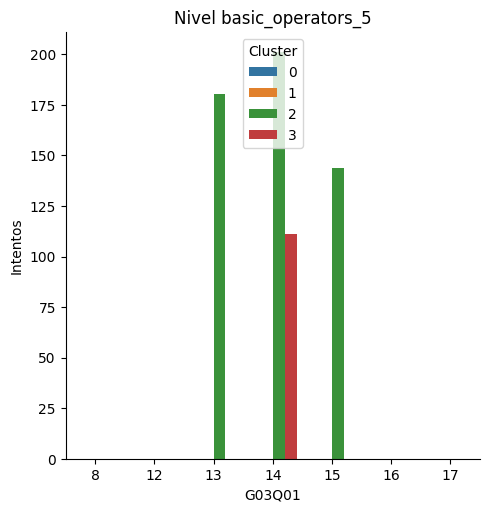

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




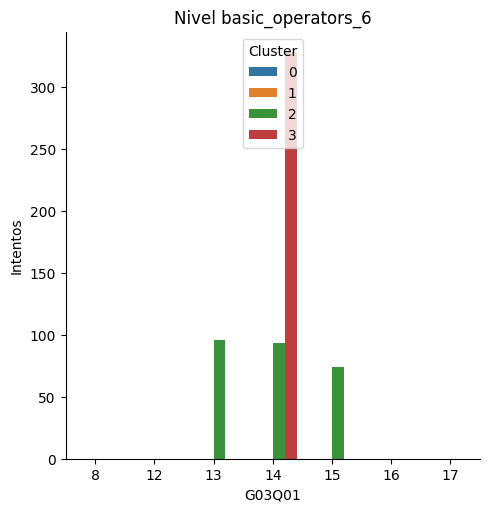

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




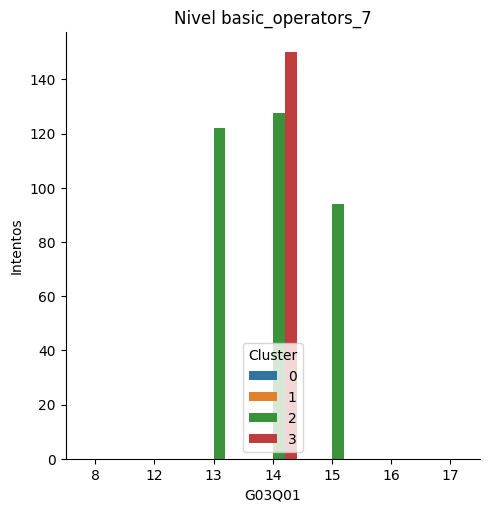

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




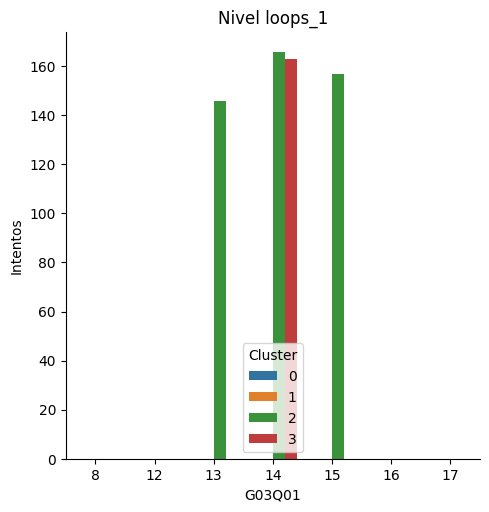

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




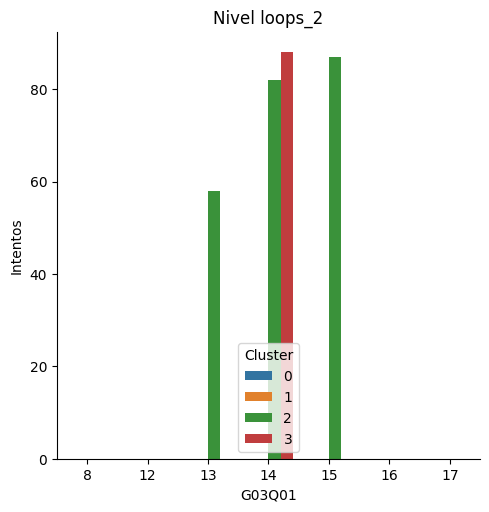

C:\Users\david\AppData\Local\Temp\ipykernel_22920\193060371.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




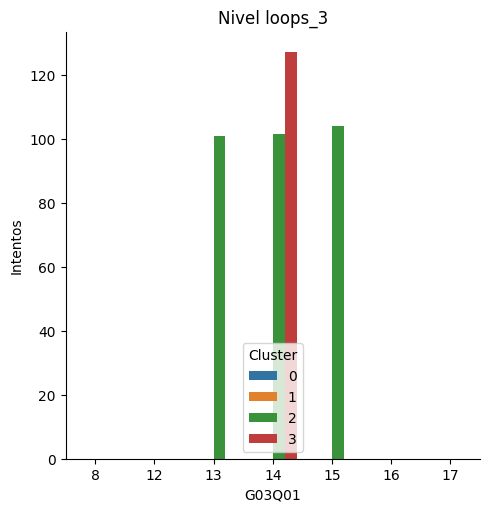

In [41]:
media_intentos = df.groupby(['G03Q02', 'G03Q01', 'Cluster'])[X.columns].mean().reset_index()
media_intentos = pd.melt(media_intentos, id_vars=['G03Q02', 'G03Q01', 'Cluster'], var_name='Nivel', value_name='Intentos')

import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para cada nivel
for nivel in intentos_df_long['Nivel'].unique():
    # Seleccionar los datos del nivel y generar una tabla pivote con los valores medios de intentos por género
    df_nivel = media_intentos[media_intentos['Nivel'] == nivel]
    pivot_table = pd.pivot_table(df_nivel, values='Intentos', index=['G03Q01'], columns=['Cluster'], aggfunc=np.mean)
    
    # Crear un gráfico de barras apiladas para comparar los valores medios de intentos por género en cada cluster
    sns.catplot(x='G03Q01', y='Intentos', hue='Cluster', data=df_nivel, kind='bar', ci=None, legend_out=False)
    plt.title(f'Nivel {nivel}')
    plt.show()
